## This is my attempt at implementing the SLANG algorithm

importing

In [33]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.linalg as alg
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
#from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

### Class defined

In [34]:
class SLANG_GaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, inital_prior_std = 0.1, inital_prior_mean = 0.0, alpha = 0.1, beta = 0.9,
                 sqrt_width_scaling=False, device=None, dtype=None, minibatch_size = 1, error = 1e-12, rank_approx = 4, noise = 1, decay = 0.51, decay_start = 100):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(SLANG_GaussianNetwork, self).__init__()
        
        # Store network dimensions and other parameters
        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0] 
        self.dim_out = layer_sizes[-1]

        self.num_params = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:])) # number of parameters
        
        self.decay = decay
        self.decay_start = decay_start
        self.alpha = alpha
        self.beta = beta
        self.minibatch_size = minibatch_size 
        self.error = error
        self.rank_approx = rank_approx
        self.noise = noise
        # prior parameters are registered as buffers so they can be alteared  
        self.register_buffer('prior_means', torch.ones(self.num_params, **factory_kwargs)*inital_prior_mean)

        # prior covariance matrix
        prior_cov = torch.diag(torch.ones(self.num_params, **factory_kwargs)*inital_prior_std)
        # prior variance scales as 1/dim_in
        if sqrt_width_scaling:  
            prior_cov /= self.dim_in ** 0.5
        
        self.prior_mean = inital_prior_mean
        self.prior_std = inital_prior_std 
    
    def ___dia_inv___(self, D):
        '''the inveres of a 2D diagonal matrix'''
        d = torch.zeros(self.num_params, self.num_params)
        for i in range(self.num_params):
            d[i,i] = 1/D[i,i]
        return d


    def ___fast_inverse___(self, g, U, D, L):
        D_inv = self.___dia_inv___(D) # D^{-1}
        I_L = torch.eye(L) # I size L
        U_Td_invU = torch.t(U) @ D_inv @ U # U^T.D^{-1}.U
        A = alg.inv(I_L + U_Td_invU) # A = (I_L + U^T.D^{-1}.U)^{-1}

        UAU_T = U @ A @ torch.t(U) # U.A.U^T
        D_inv_g = D_inv @ g # D^{-1}.g
        y = D_inv_g - D_inv @ UAU_T @ D_inv_g  # D^{-1}.g - D^{-1}.U^T.A.U.D^{-1}.g

        return y

    


    def ___fast_sample___(self, mean, U, D, L):
        '''since covarance matrix approx is equal to (D + UU^T)^{-1} the squar root of (D + UU^T)^{-1} gives us what we need for the reparametivation trick'''
        eps = torch.normal(0,1,size = (self.num_params, 1))
        #Dinv_root = self.___dia_inv___(D)**(1/2) # D^(-1/2)
        #V = Dinv_root @ U # V = D^(-1/2) U
        #VtV = torch.t(V) @ V 
        #I_L = torch.eye(L)
        #A = torch.inverse(alg.cholesky(VtV))
        #A_inv = torch.inverse(alg.cholesky(VtV))
        #B = alg.cholesky(VtV + I_L)
        #C_inv = torch.inverse(torch.t(A_inv) @ (B - I_L) @ A_inv)
        #K = torch.inverse(C_inv + VtV)
        #sig = Dinv_root - Dinv_root @ V @ K @ torch.t(V)
        #print('sig', alg.matrix_norm(sig @ torch.t(sig) @ (U @ torch.t(U) + D) - torch.eye(self.num_params)), alg.matrix_norm(A @ torch.t(A) - torch.t(A) @ A))
        #y = Dinv_root @ eps - Dinv_root @ V @ K @ torch.t(V) @ eps
        #+ torch.squeeze(y)
        Dinv_root = self.___dia_inv___(D)**(1/2) # D^(-1/2)
        V = Dinv_root @ U # V = D^(-1/2) U
        Sig = Dinv_root @ (torch.eye(self.num_params) - V @ torch.inverse(torch.eye(L) + torch.t(V) @ V) @ torch.t(V)) @ Dinv_root
        pse = 1e-6 * torch.eye(self.num_params)
        Sig_root_eps = alg.cholesky(Sig + pse) @ eps
        return mean + torch.squeeze(Sig_root_eps)

    def ___minibatch___(self, M, N, data):
        if M == data.size()[0]:
            return data
        p = torch.ones(N)/N
        index = p.multinomial(num_samples=M)
        return data[index]


    def ___conditional___(self, D, U, D_p, U_p):
        current_approx = D + U @ torch.t(U)
        pevious_approx = D_p + U_p @ torch.t(U_p)
        
        return alg.matrix_norm(current_approx - pevious_approx) < self.error

    def SLANG(self, data):
        # Initializing
        L = self.rank_approx
        mean = self.prior_means
        U = torch.rand((self.num_params, L), requires_grad=True)
        D = torch.diag(torch.ones(self.num_params, requires_grad=True)*self.prior_std)

        # previous U and D
        U_p = torch.zeros((self.num_params, L), requires_grad=True) 
        D_p = torch.zeros((self.num_params, self.num_params), requires_grad=True)

        lamb = 1/self.prior_std * torch.ones(self.num_params)
        alpha = self.alpha
        beta = self.beta
        M = self.minibatch_size
        N = data.shape[0]
        counter = 0 
        iter = 0
        while counter < 2:
            
            if self.___conditional___(D, U, D_p, U_p):
                counter += 1 
            else:
                counter = 0
            
            # generatind a sample from  θ_t ∼ N (θ|µ_t, U_tU_t^T + D_t).
            theta = self.___fast_sample___(mean, U, D, L)

            # sample a minibatch
            data_M = self.___minibatch___(M,N, data)

            # backprop
            g = self.___backprop_goodfellow___(M, data_M, theta) #, D + U @ torch.t(U), mean_p, D_p + U_p @ torch.t(U_p))

            # getting the the matrix Q_{1:L}\Lamda_{1:L}^{1/2}
            G_hat = N/M*sum([g[:,i:i+1] @ torch.t(g[:,i:i+1]) for i in range(M)])
            A = (1 - beta)*(U @ torch.t(U)) + beta*G_hat # are approximation is herman 
            V = self.___fast_eig___(A, L) 

            grad_d = (1 - beta) * (U**2).sum(dim=1) + beta * (g**2).sum(dim=1) - (V**2).sum(dim=1)

            # updating U and D
            U_p = U 
            D_p = D
            
            U = V
            D = torch.diag((1 - beta)*torch.diagonal(D) + grad_d + beta*lamb)

            # caculating 
            mu_lamb = torch.zeros(self.num_params)
            for i in range(self.num_params):
                mu_lamb += lamb[i]*mean[i]
            g_hat = sum([g[:,i] for i in range(M)]) + mu_lamb
            grad_mean = self.___fast_inverse___(g_hat, U, D, L)
            mean = mean - alpha*grad_mean

            if iter > self.decay_start:
                alpha = alpha*self.decay
                beta = beta*self.decay
            else:
                iter += 1

            # updating prior
            

            
            current_approx = D + U @ torch.t(U)
            pevious_approx = D_p + U_p @ torch.t(U_p)
            print('error', alg.matrix_norm(current_approx - pevious_approx))

        cov = torch.inverse(D + U @ torch.t(U))
        return mean, cov

    def ___Q_from_qr___(self, A):
        Q, _ = alg.qr(A)
        return Q

    def ___nystrom___(self, U, Q, anorm):
        """
        Use the Nystrom method to obtain approximations to the
        eigenvalues and eigenvectors of A (shifting A on the subspace
        spanned by the columns of Q in order to make the shifted A be
        positive definite).
        """
        
        def ___svd_thin_matrix___(A):
            """
            Efficient implementation of SVD on [N x D] matrix, D >> N.
            """
            (e, V) = alg.eigh(A @ A.t())
            
            Sigma = torch.sqrt(e)
            SigInv = 1/Sigma 
            SigInv[torch.isnan(SigInv)] = 0
            U = A.t() @ (V * SigInv)
            
            return U, Sigma, V
            
        anorm = .1e-6 * anorm * math.sqrt(1. * self.num_params)
        E = U @ Q + anorm * Q
        R = Q.t() @ E
        R = (R + R.t()) / 2
        R = alg.cholesky(R, upper=False) # Cholesky
        tmp = alg.solve(R, E.t()) # Solve
        V, d, _ = ___svd_thin_matrix___(tmp)
        d = d * d - anorm
        return d, V

    # Alot of this this copped 
    def ___fast_eig___(self, A, L, n_iter = 8): # ?
        # From Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositi page 35 see usefull reading
        # and based on the Github https://github.com/aaronpmishkin/SLANG 
        K = L + 2
        Q = 2*(torch.rand((self.num_params, K), device= A.device, dtype= A.dtype)-0.5)
        for _ in range(max(0, n_iter-1)):
            Q = self.___Q_from_qr___(A @ Q)
        
        oldQ = Q
        
        Q = A @ Q
        anorm = torch.max(torch.norm(Q, dim=0)/torch.norm(oldQ, dim=0))
        Q = self.___Q_from_qr___(Q)
        
        d, V = self.___nystrom___(A, Q, anorm)

        # Retain only the entries with the k greatest absolute values
        _, idx = torch.abs(d).sort()
        idx = idx[:L]
        #print(alg.matrix_rank(V[:, idx]), d[idx])
        return V[:, idx] @ torch.diag(abs(d[idx])**0.5)

    
    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input  
    
    def ___backprop_goodfellow___(self, M, data_M, theta):#, cov, mean_p, cov_p):
        theta.retain_grad()
        g = torch.zeros((self.num_params, M))
        for i in range(M):
            # forward pass
            pred = self.forward(data_M[i, :1], theta)
            # backward pass with the log likelihood i.e. logp(Di|θt)
            pred.backward(-1/(self.noise**2) * (data_M[i, 1:] - pred), retain_graph=True)
            g[:,i] += theta.grad
            theta.grad.zero_() # zero the gradients for the next sample
            
        return g
    


### Testing

In [35]:
net = SLANG_GaussianNetwork([1,2,1], alpha = 0.1, beta = 0.9,
                             inital_prior_std=10,  rank_approx = 2,  
                             minibatch_size = 3, decay=0.51, decay_start=10, error = 1e-7)
data = torch.tensor([[0.01, 0.02], [1.5, 3.0], [1.2, 2.8], [5.05, 10.3], [1.6, 2.9], [1.5, 3.2], [1.3, 3.0]],   
                     requires_grad=True)


# Compute the cov wrt the sampled network parameters

mean, Sig = net.SLANG(data)
print('mean', mean)
print('cov', Sig)

error tensor(26.5457, grad_fn=<LinalgVectorNormBackward0>)
error tensor(26.2406, grad_fn=<LinalgVectorNormBackward0>)
error tensor(836.0994, grad_fn=<LinalgVectorNormBackward0>)
error tensor(753.4922, grad_fn=<LinalgVectorNormBackward0>)
error tensor(124.8736, grad_fn=<LinalgVectorNormBackward0>)
error tensor(13889.2803, grad_fn=<LinalgVectorNormBackward0>)
error tensor(12520.3389, grad_fn=<LinalgVectorNormBackward0>)
error tensor(1239.7130, grad_fn=<LinalgVectorNormBackward0>)
error tensor(197.5573, grad_fn=<LinalgVectorNormBackward0>)
error tensor(91.0208, grad_fn=<LinalgVectorNormBackward0>)
error tensor(100.5765, grad_fn=<LinalgVectorNormBackward0>)
error tensor(22.7037, grad_fn=<LinalgVectorNormBackward0>)
error tensor(9.2233, grad_fn=<LinalgVectorNormBackward0>)
error tensor(904.0473, grad_fn=<LinalgVectorNormBackward0>)
error tensor(112.9346, grad_fn=<LinalgVectorNormBackward0>)
error tensor(150.4736, grad_fn=<LinalgVectorNormBackward0>)
error tensor(31.0579, grad_fn=<LinalgVect

### Regression Ground Truth & Dataset

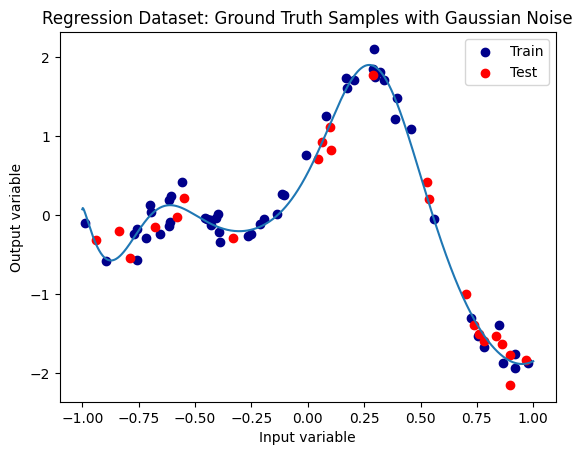

C:\Users\james\AppData\Local\Temp\ipykernel_44564\496023080.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data_tr = torch.FloatTensor(data_tr).unsqueeze(-1)


In [20]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=75, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
data_tr = []
for i in range(len(x_tr)):
    data_tr.append([x_tr, y_tr])

data_te = []
for i in range(len(x_te)):
    data_te.append([x_te, y_te])


data_tr = torch.FloatTensor(data_tr).unsqueeze(-1)
data_te = torch.FloatTensor(data_te).unsqueeze(-1)


### Training

In [30]:
net = SLANG_GaussianNetwork([1,6,8,7,1], alpha = 0.1, beta = 0.9,
                             inital_prior_std=10,  rank_approx = 2,  
                             minibatch_size = 5, decay=0.51, decay_start=10, error = 1e-7)



mean, cov = net.SLANG(data_tr)

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()
    

error tensor(20632.9375, grad_fn=<LinalgVectorNormBackward0>)
error tensor(26439738., grad_fn=<LinalgVectorNormBackward0>)
error tensor(23796154., grad_fn=<LinalgVectorNormBackward0>)
error tensor(2379608.5000, grad_fn=<LinalgVectorNormBackward0>)
error tensor(939955.5625, grad_fn=<LinalgVectorNormBackward0>)
error tensor(824259.3125, grad_fn=<LinalgVectorNormBackward0>)
error tensor(3.2056e+13, grad_fn=<LinalgVectorNormBackward0>)
error tensor(1.7410e+13, grad_fn=<LinalgVectorNormBackward0>)
error tensor(1.1086e+12, grad_fn=<LinalgVectorNormBackward0>)
error tensor(1.4488e+11, grad_fn=<LinalgVectorNormBackward0>)
error tensor(8.5720e+10, grad_fn=<LinalgVectorNormBackward0>)
error tensor(2.5733e+11, grad_fn=<LinalgVectorNormBackward0>)
error tensor(3.8891e+11, grad_fn=<LinalgVectorNormBackward0>)
error tensor(1.2493e+11, grad_fn=<LinalgVectorNormBackward0>)
error tensor(5.1965e+10, grad_fn=<LinalgVectorNormBackward0>)
error tensor(2.4152e+10, grad_fn=<LinalgVectorNormBackward0>)
error 

In [32]:
print(mean,cov)

plot()



tensor([ 4.8891e-01, -3.6740e-02,  1.5308e-01, -1.4147e-01,  6.2138e-01,
        -4.9978e-02,  1.0061e-01,  2.4506e-02,  6.2883e-02,  9.0109e-02,
         3.8567e-01, -7.7151e-03,  8.9863e+00,  7.1817e+00,  3.5485e+00,
         2.8649e+00,  8.3239e+00,  7.9569e+00,  1.4148e+00,  1.9736e+00,
        -7.7199e-02,  8.0793e+00,  2.9749e+00,  6.9603e+00,  9.2912e+00,
         8.9005e+00,  8.5768e+00,  8.7754e+00,  8.4914e+00,  8.3470e+00,
         8.7001e+00,  4.6462e+00, -1.8290e-01,  8.7187e+00,  6.3195e+00,
         1.3330e+00,  7.1722e-01,  8.4453e+00,  7.6111e+00,  8.5558e+00,
         8.5810e+00,  8.1858e+00,  8.5286e+00,  9.5950e+00,  6.9253e+00,
         8.1762e+00,  8.7096e+00,  8.6482e+00,  8.5819e+00,  7.5069e+00,
         6.5109e+00,  2.4073e+00,  8.6122e+00,  8.4978e+00,  4.3823e-01,
         7.9650e+00,  3.3528e+00,  3.0792e+00,  8.6154e+00,  8.5254e+00,
        -3.7158e-02, -3.2328e-02,  4.7213e+00, -2.8751e-02,  3.6715e-01,
         6.4744e-01,  1.2482e-01,  6.4075e-02,  8.5